In [86]:
compounds_str = """
part1-CO2_50-FeO_50:
CO2: 50%
FeO: 50%

part2-CO_20-Fe_50-AgO_20-AlO_10:
CO: 20%
Fe: 50%
AgO: 20%
AlO: 10%

part3-HCO2_15-FeO2_60-Ag_25:
HCO2: 15%
FeO2: 60%
Ag: 25%

part4-HCO2_20-FeO2_60-Ag_20:
HCO2: 20%
FeO2: 60%
Ag: 20%
"""
import torch
import datetime
from typing import List, Tuple, Literal
from dataclasses import dataclass
import importlib

import mark_essential_oils
importlib.reload(mark_essential_oils)
from mark_essential_oils import Config, gen_examples, train

import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib.ticker import LogLocator
from matplotlib.patches import ConnectionPatch
from IPython import display

# import seaborn as sns
# import pandas
# sns.set_theme()

@dataclass
class Annotation:
    text: str
    xy: Tuple[float, float]
    axes: str
    textxy: Tuple[float, float] = None


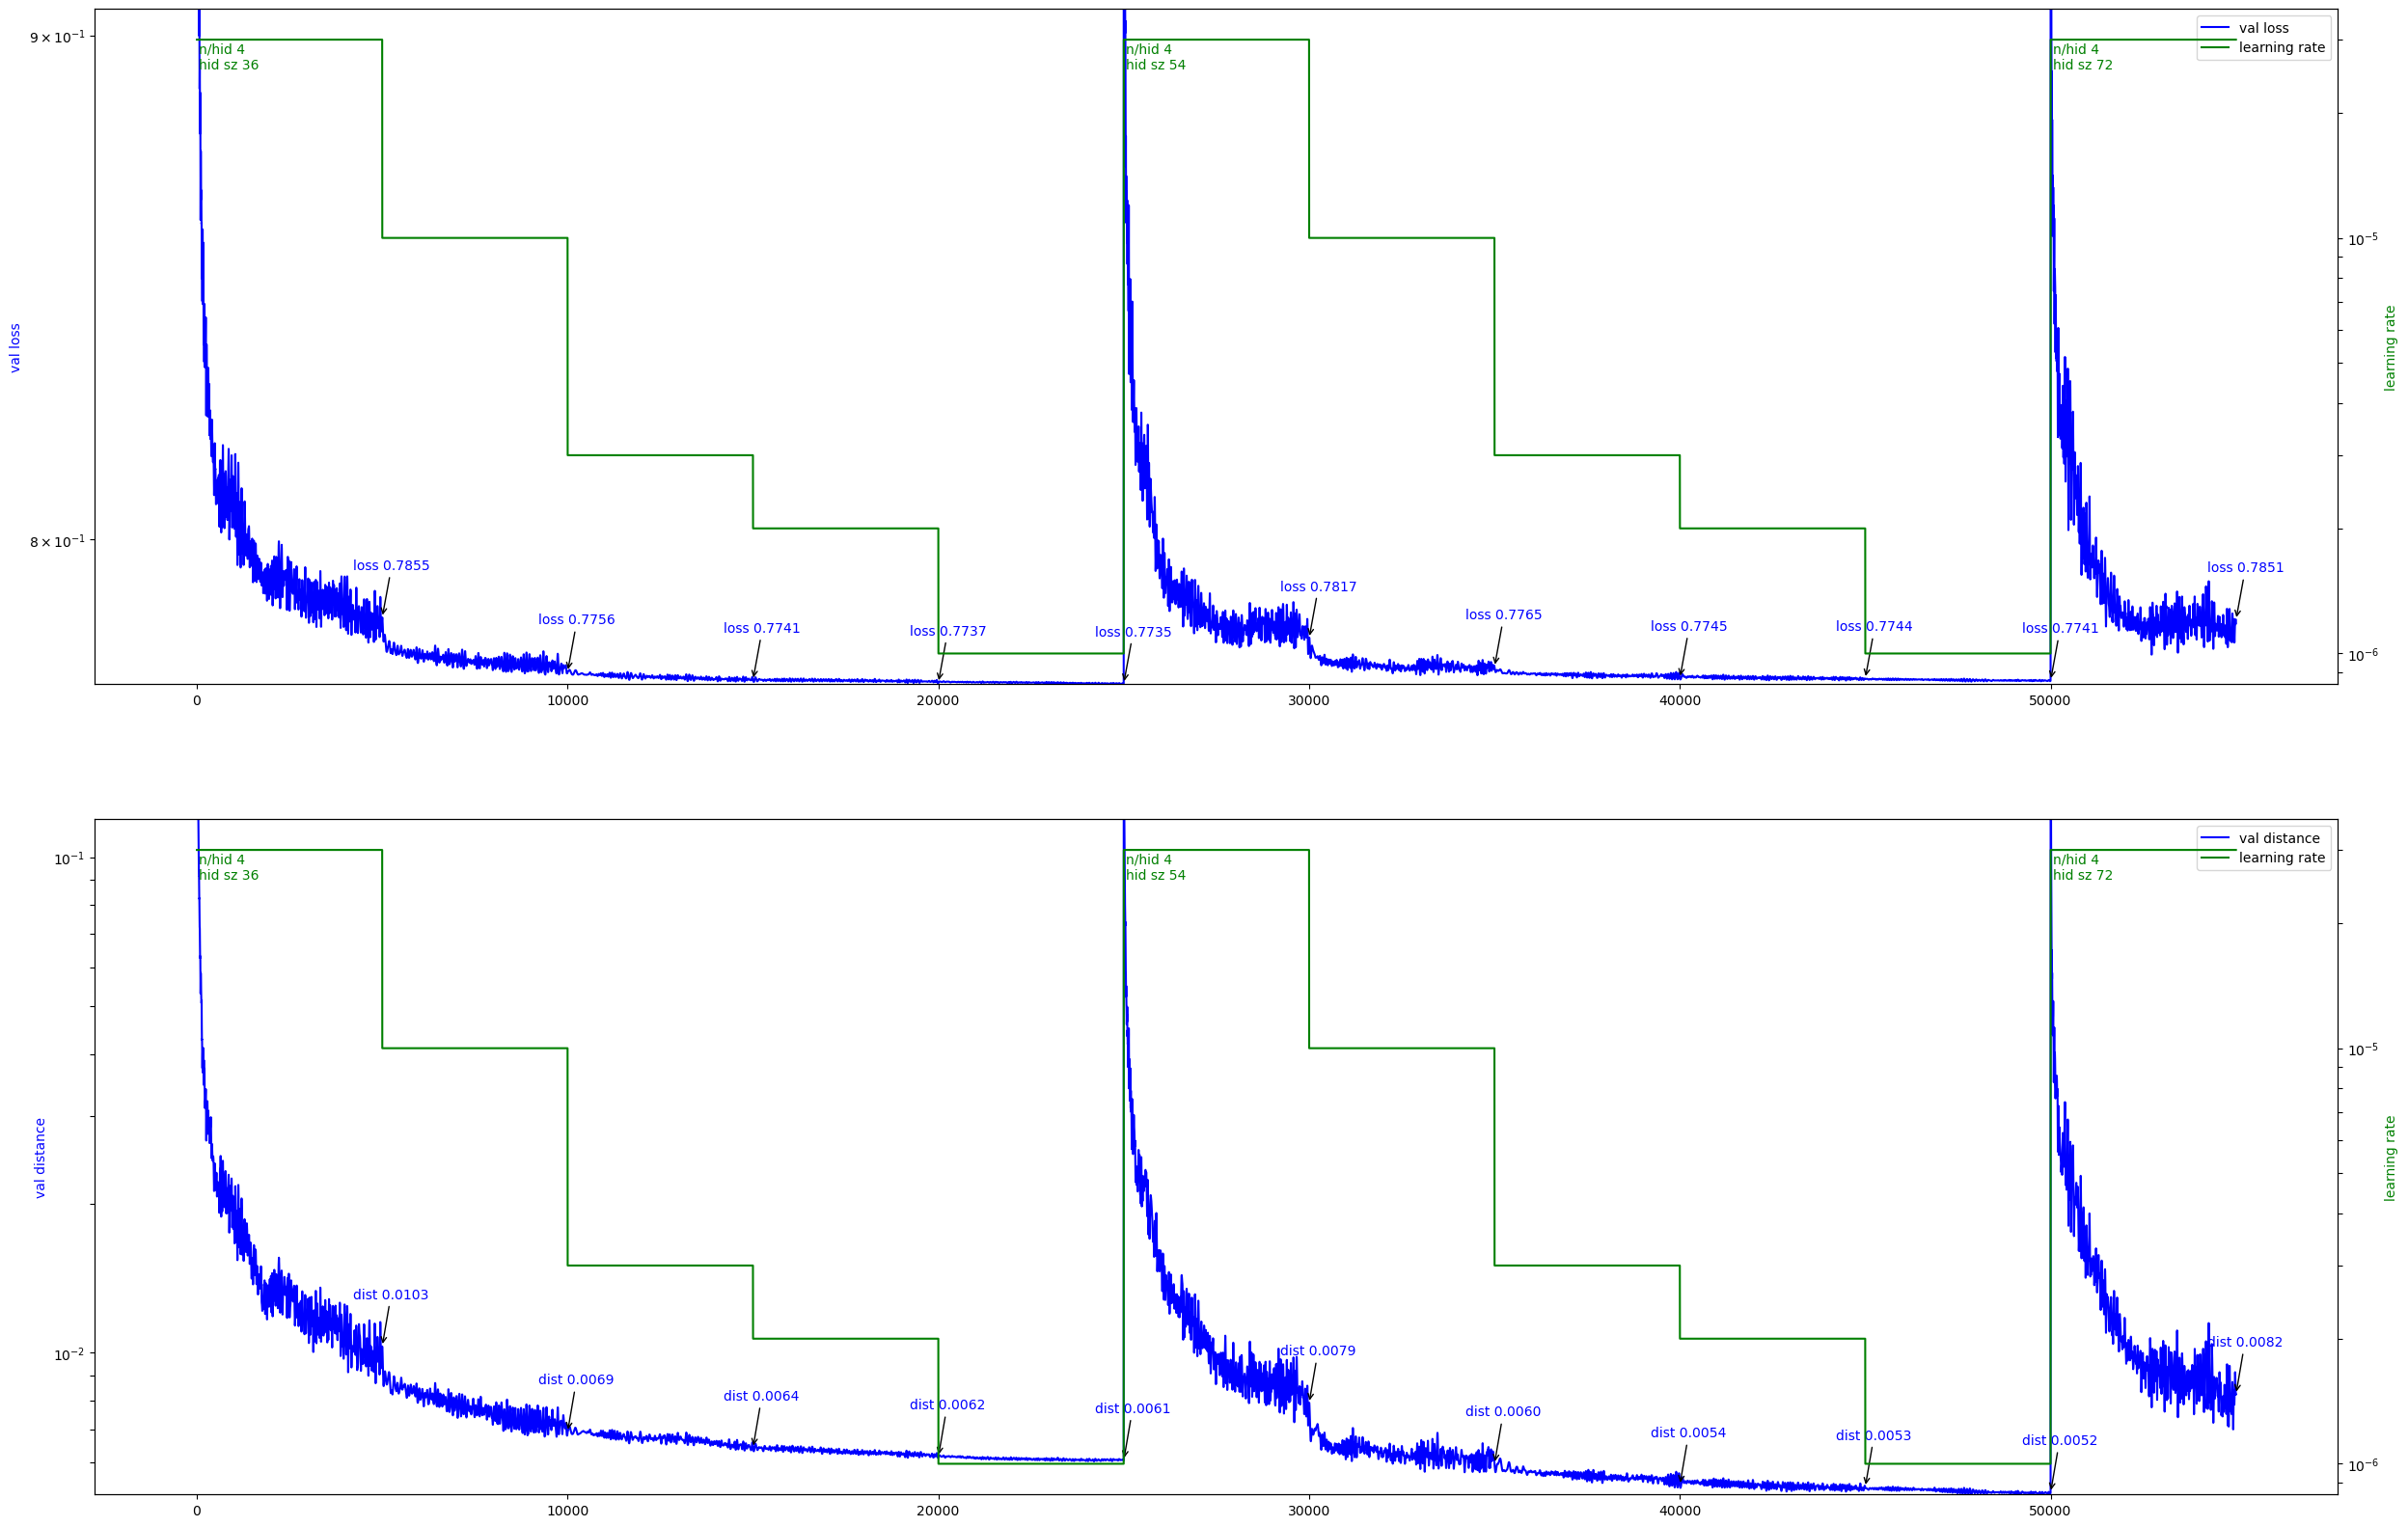

saved outputs/mark_essential_oils2/results-20230217-011942.png & outputs/mark_essential_oils2/results-20230217-011942-lr_3e-05-num_hidden_4-hidden_size_72-epoch05000.torch
lr = 1e-05 (num_hidden 4, hidden_size 72)
epoch 157/5000: train loss 0.77598, val loss 0.77805, val dist 0.00667
epoch 315/5000: train loss 0.77556, val loss 0.77782, val dist 0.00672
epoch 472/5000: train loss 0.77488, val loss 0.77768, val dist 0.00650
epoch 630/5000: train loss 0.77418, val loss 0.77706, val dist 0.00642
epoch 787/5000: train loss 0.77394, val loss 0.77757, val dist 0.00654
epoch 946/5000: train loss 0.77404, val loss 0.77745, val dist 0.00637
epoch 1102/5000: train loss 0.77384, val loss 0.77641, val dist 0.00623
epoch 1260/5000: train loss 0.77425, val loss 0.77801, val dist 0.00654
epoch 1417/5000: train loss 0.77375, val loss 0.77786, val dist 0.00666
epoch 1574/5000: train loss 0.77348, val loss 0.77719, val dist 0.00619
epoch 1731/5000: train loss 0.77333, val loss 0.77735, val dist 0.00625


KeyboardInterrupt: 

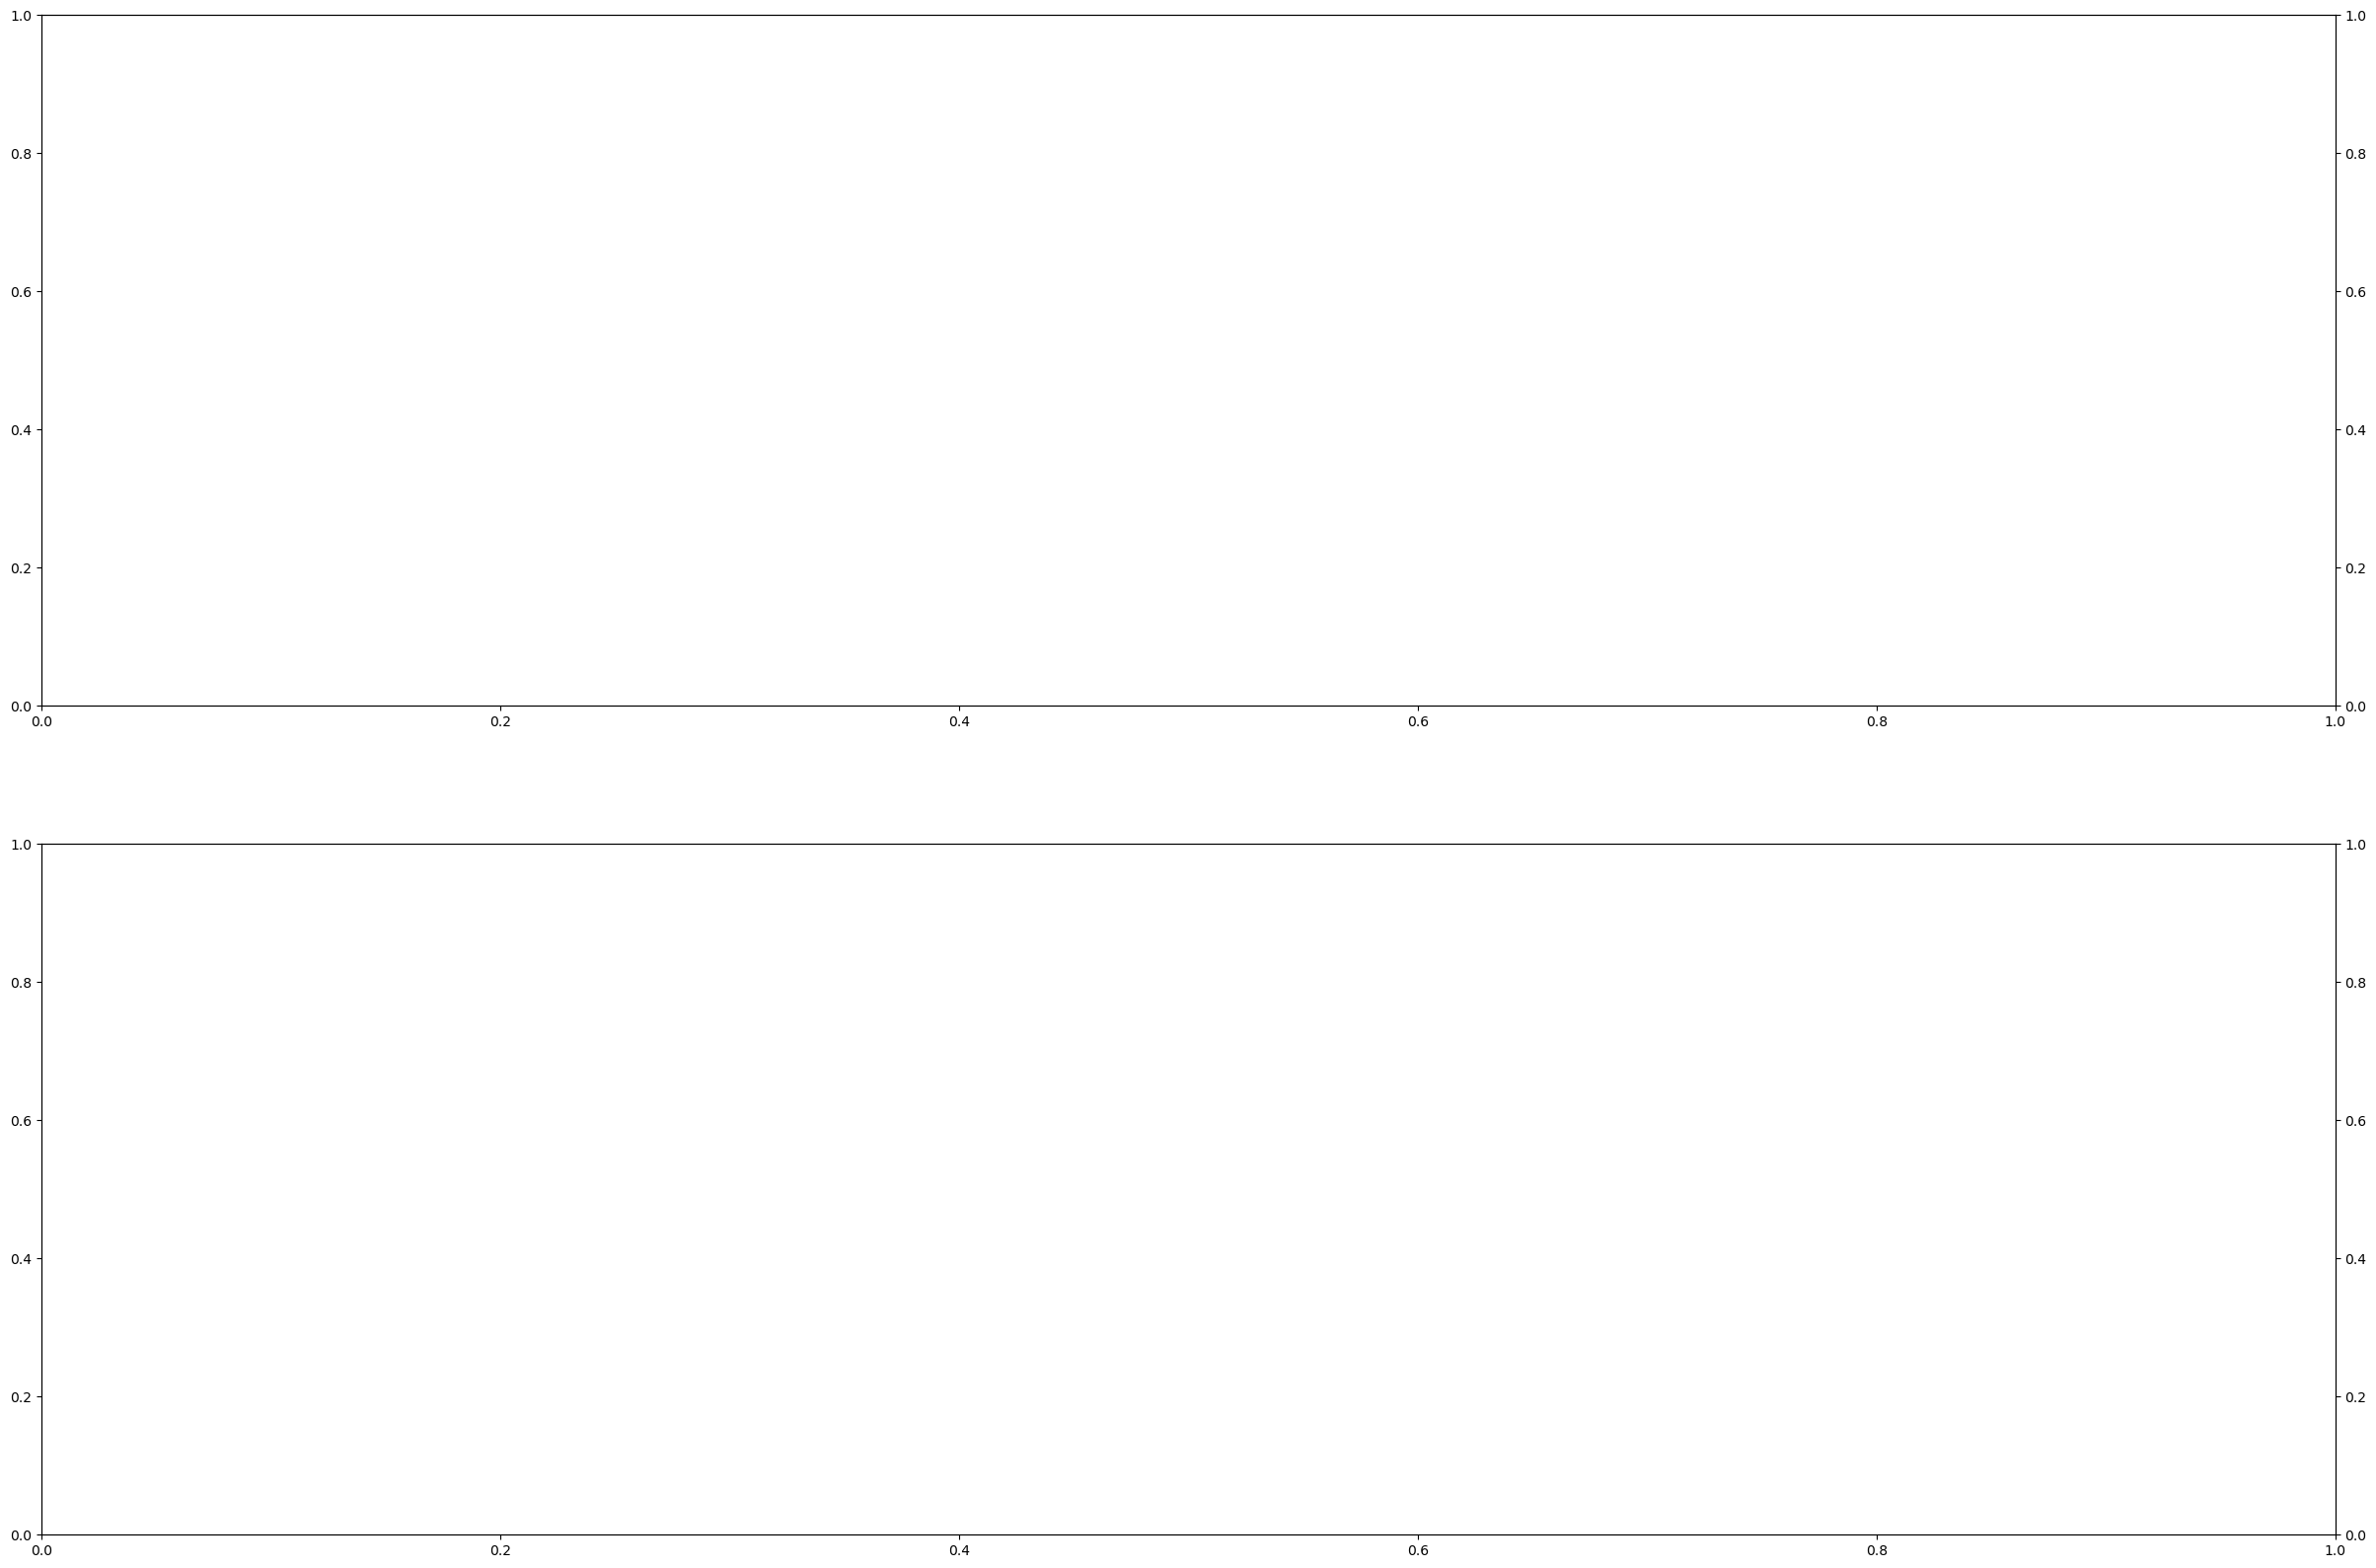

In [106]:

%matplotlib inline
cfg = Config(compounds_str)
cfg.setup(num_hidden=3, hidden_size=len(cfg.all_mol_names), lr=1e-4)

annotations: List[Annotation] = list()

color_val = "blue"
color_lr = "green"
fig = plt.gcf()

def reset_plot(val_loss_min: float, val_loss_max: float, val_dist_min: float, val_dist_max: float):
    plt.rcParams["figure.figsize"] = (30, 20) # (w, h)
    fig.clear()
    ax_val_losses = fig.add_subplot(2, 1, 1, label="val loss")
    ax_val_dists = fig.add_subplot(2, 1, 2, label="val distance")

    all_axes = [ax_val_losses, ax_val_dists]
    all_axes_lr = [ax.twinx() for ax in all_axes]

    for ax in all_axes_lr:
        ax.set_yscale("log")
        ax.set_label("learning rate")
        ax.set_ylabel(ax.get_label(), color=color_lr)
        ax.yaxis.set_major_locator(LogLocator(subs='all'))
        ax.yaxis.set_minor_locator(LogLocator(subs='all'))

    for ax in all_axes:
        ax.set_yscale("log")
        ax.set_ylabel(ax.get_label(), color=color_val)
        ax.yaxis.set_major_locator(LogLocator(subs='all'))
        ax.yaxis.set_minor_locator(LogLocator(subs='all'))

    ax_val_losses.set_ylim(bottom=val_loss_min, top=val_loss_max + 0.1)
    ax_val_dists.set_ylim(bottom=val_dist_min, top=val_dist_max + 0.1)

    return all_axes, all_axes_lr

num_mol = len(cfg.all_mol_names)
hp_num_batches = 10
hp_batch_size = 1000
hp_learning_rates = {3e-5: 5000, 1e-5: 5000, 3e-6: 5000, 2e-6: 5000, 1e-6: 5000}
hp_num_hidden = [4, 6, 8, 10]
# hp_hidden_size = [num_mol * 6, num_mol * 8, num_mol * 10]
# hp_hidden_size = [num_mol * 6]
hp_hidden_size = [i * num_mol for i in range(4, 12, 2)]

# TODO - only for fast debugging
# hp_learning_rates = {k: v//100 for k, v in hp_learning_rates.items()}

data_train = gen_examples(cfg, hp_num_batches, hp_batch_size)
data_val = gen_examples(cfg, hp_num_batches, hp_batch_size)

train_loss_hist = torch.zeros((sum(hp_learning_rates.values()) * len(hp_num_hidden) * len(hp_hidden_size), ))
val_loss_hist = torch.zeros_like(train_loss_hist)
val_loss_min, val_loss_max = 1000000.0, 0.0
val_dist_hist = torch.zeros_like(train_loss_hist)
val_dist_min, val_dist_max = 1000000.0, 0.0
lr_hist = torch.ones_like(train_loss_hist)

timestr = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
base_filename = ["outputs", "mark_essential_oils2", "results-" + timestr]
base_filename = "/".join(base_filename)

config_idx = 0
total_epochs = 0
for num_hidden in hp_num_hidden:
    for hidden_size in hp_hidden_size:
        cfg.setup(num_hidden=num_hidden, hidden_size=hidden_size, lr=1e-4)

        print()
        print(f"num_hidden {num_hidden}, hidden_size {hidden_size}")
        epochs_at_lr = 0

        for lridx, (lr, epochs) in enumerate(hp_learning_rates.items()):
            print(f"lr = {lr} (num_hidden {num_hidden}, hidden_size {hidden_size})")
            cfg.optim = torch.optim.AdamW(cfg.net.parameters(), lr=lr)

            tlosses, vlosses, vdists = train(cfg, epochs, data_train, data_val)

            size_sofar = total_epochs + epochs
            idx_sofar = size_sofar - 1

            train_loss_hist[total_epochs:total_epochs + epochs] = tlosses
            val_loss_hist[total_epochs:total_epochs + epochs] = vlosses
            val_dist_hist[total_epochs:total_epochs + epochs] = vdists
            lr_hist[total_epochs:total_epochs + epochs] *= lr

            # throw away the top of loss & distance, as they are probably the first epochs of 
            # the run and the network is totally untrained.
            val_loss_max = max(val_loss_max, torch.quantile(vlosses[:size_sofar], torch.tensor(0.6)).item())
            val_dist_max = max(val_dist_max, torch.quantile(vdists[:size_sofar], torch.tensor(0.6)).item())
            val_loss_min = min(val_loss_min, torch.min(vlosses[:size_sofar]).item())
            val_dist_min = min(val_dist_min, torch.min(vdists[:size_sofar]).item())

            all_axes, all_axes_lr = reset_plot(val_loss_min, val_loss_max, val_dist_min, val_dist_max)
            all_vals_sofar = [val_loss_hist[:size_sofar], val_dist_hist[:size_sofar]]
            lr_hist_sofar = lr_hist[:size_sofar]

            # annotation for hyper param change
            lrpos = (float(total_epochs), lr_hist[total_epochs].item())
            if lridx == 0:
                annotext = f"n/hid {num_hidden}\nhid sz {hidden_size}"
                anno = Annotation(text=annotext, xy=lrpos, axes="learning rate")
                annotations.append(anno)

            # annotation for ending loss for that learning rate
            textpos = (idx_sofar, lr_hist_sofar[-1].item())
            annotext = f"loss {val_loss_hist[idx_sofar]:.4f}"
            annopos = (textpos[0], val_loss_hist[idx_sofar].item())
            anno = Annotation(annotext, xy=annopos, axes="val loss") #, textxy=textpos)
            annotations.append(anno)

            annotext = f"dist {val_dist_hist[idx_sofar]:.4f}"
            annopos = (textpos[0], val_dist_hist[idx_sofar])
            anno = Annotation(annotext, xy=annopos, axes="val distance") #, textxy=textpos)
            annotations.append(anno)

            for axes, axes_lr, vals in zip(all_axes, all_axes_lr, all_vals_sofar):
                axes.plot(vals, color=color_val, label=axes.get_label())
                lines, labels = axes.get_legend_handles_labels()

                axes_lr.plot(lr_hist_sofar[:-1], color=color_lr, label=axes_lr.get_label())
                lines_lr, labels_lr = axes_lr.get_legend_handles_labels()

                axes.legend(lines + lines_lr, labels + labels_lr)

                for anno in annotations:
                    kvargs = {}
                    use_axes: plt.Axes = None
                    if anno.axes == axes_lr.get_label():
                        xoff = 2
                        yoff = (anno.text.count("\n") + 1) * -15
                        color = color_lr
                        use_axes = axes_lr

                    elif anno.axes == axes.get_label():
                        xoff, yoff = -30, 50
                        color = color_val
                        use_axes = axes

                        if anno.textxy is not None:
                            # con = ConnectionPatch(xyA=anno.xy, axesA=axes,
                            #                       xyB=anno.textxy, axesB=axes_lr,
                            #                       coordsA="data", coordsB="data")
                            # axes_lr.add_artist(con)
                            kvargs = dict(xytext=anno.textxy, textcoords=axes_lr.transData, arrowprops=dict(arrowstyle='->'))
                        else:
                            kvargs = dict(xytext=(xoff, yoff), textcoords='offset pixels', arrowprops=dict(arrowstyle='->'))
                    else:
                        continue

                    if not kvargs:
                        kvargs = dict(xytext=(xoff, yoff), textcoords='offset pixels')
                    use_axes.annotate(text=anno.text, xy=anno.xy, color=color, **kvargs)
                
            display.clear_output(True)
            display.display(fig)

            epochs_at_lr += epochs
            total_epochs += epochs

            torch_filename = f"{base_filename}-lr_{lr}-num_hidden_{num_hidden}-hidden_size_{hidden_size}-epoch{epochs_at_lr:05}.torch"
            torch.save(cfg.net, torch_filename)
            img_filename = f"{base_filename}.png"
            fig.savefig(img_filename)
            print(f"saved {img_filename} & {torch_filename}")

            for ax in [*all_axes, *all_axes_lr]:
                ax.clear()


In [ ]:
tensors = [m.weight.grad for m in cfg.net.modules() if isinstance(m, torch.nn.Linear)]
# tensors = [t.abs() > 0.001 for t in tensors]
tensors = [t.abs() < .01 for t in tensors]
# tensors = [torch.clamp(t, min=-1.0+1e-7, max=1.0-1e-7) for t in tensors]
# tensors = [m.weight for m in cfg.net.modules() if isinstance(m, torch.nn.Linear)]
count_all_rows = max([t.shape[0] for t in tensors])
count_all_cols = sum([t.shape[1] for t in tensors])

all_tensors = torch.zeros((count_all_rows, count_all_cols))
running_col = 0
for t in tensors:
    trows, tcols = t.shape
    print(f"trows {trows}, tcols {tcols}")
    print(f"[:{trows}, {running_col}:{running_col+tcols}] = {t.shape}")
    all_tensors[:trows, running_col:running_col+tcols] = t
    running_col += tcols

plt.matshow(all_tensors.detach().cpu(), cmap=matplotlib.cm.gray, vmin=-1, vmax=1)
all_tensors
